## Import

In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 4.9MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import DenseNet121
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

# example of loading the mnist dataset
from keras.datasets import mnist
from matplotlib import pyplot

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGES_PATH = '/content/drive/MyDrive/Data/plant-pathology-2020-fgvc7/images'
TRAIN_PATH = '/content/drive/MyDrive/Data/plant-pathology-2020-fgvc7/train.csv'
TEST_PATH = '/content/drive/MyDrive/Data/plant-pathology-2020-fgvc7/sample_submission.csv'

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)

## Data Exploration

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
train_df.shape

(1821, 5)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [ ]:
train_df.duplicated().sum()

0

In [ ]:
train_df.healthy.sum() + train_df.multiple_diseases.sum() + train_df.rust.sum() + train_df.scab.sum()

1821

=> So that the value of 1 appears only once time on each record

## Data Preprocessing

In [ ]:
train_labels = np.float32(train_df.loc[:, 'healthy':'scab'].values)
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
train_df.image_id = train_df.image_id.apply(lambda x: x+'.jpg')

In [ ]:
cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
label = []

for i in range(len(train_df)):
  for col in cols:
    if train_df.iloc[i][col] == 1:
      label.append(col)
      break

train_df['label'] = label

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0.jpg,0,0,0,1,scab
1,Train_1.jpg,0,1,0,0,multiple_diseases
2,Train_2.jpg,1,0,0,0,healthy
3,Train_3.jpg,0,0,1,0,rust
4,Train_4.jpg,1,0,0,0,healthy


In [ ]:
## import image dateset
datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split= 0.2)


HEIGHT = 124
WIDTH = 124
SEED = 143
BATCH_SIZE = 32

## generate training dataset
train_ds = datagen.flow_from_dataframe(
    train_df,
    directory = IMAGES_PATH,
    x_col = 'image_id',
    y_col = 'label',
    subset="training",
    color_mode="rgb",
    target_size = (HEIGHT,WIDTH),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

## generate validation dataset
val_ds = datagen.flow_from_dataframe(
    train_df,
    directory = IMAGES_PATH,
    x_col = 'image_id',
    y_col = 'label',
    subset="validation",
    color_mode="rgb",
    target_size = (HEIGHT,WIDTH),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


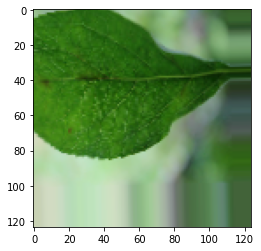

In [ ]:
## show a sample of image
image = train_ds.next()[0][0,:,:,:]
plt.imshow(image)
plt.show()

## CNN Model Building

In [ ]:
## fault tolerance technique for long running processes.
checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(r'resnet.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          save_weights_only=True,
                          verbose=1)

checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(r'densenet.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          save_weights_only=True,
                          verbose=1)

checkpoint_3 = tf.keras.callbacks.ModelCheckpoint(r'efficientnet.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          save_weights_only=True,
                          verbose=1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)


### ResNet

In [ ]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(124,124,3))
x = resnet.output
x = L.GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
resnet = Model(inputs=resnet.input, outputs=predictions)
resnet.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
resnet.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 23,858,500
Trainable params: 23,805,380
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [ ]:
## Fit the Model with training dataset
history_1 = resnet.fit(train_ds,
                      validation_data=val_ds,
                      epochs=40,
                      steps_per_epoch=train_ds.samples//128,
                      validation_steps=val_ds.samples//128,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001), checkpoint_1,earlystop])

Epoch 1/40
11/11 [==============================] - 255s 21s/step - loss: 11.8983 - accuracy: 0.3056 - val_loss: 1.4056 - val_accuracy: 0.1719

Epoch 00001: val_loss improved from inf to 1.40565, saving model to resnet.h5
Epoch 2/40
11/11 [==============================] - 225s 22s/step - loss: 1.4395 - accuracy: 0.3212 - val_loss: 1.2964 - val_accuracy: 0.3438

Epoch 00002: val_loss improved from 1.40565 to 1.29636, saving model to resnet.h5
Epoch 3/40
11/11 [==============================] - 226s 23s/step - loss: 1.2474 - accuracy: 0.3664 - val_loss: 1.2085 - val_accuracy: 0.4062

Epoch 00003: val_loss improved from 1.29636 to 1.20851, saving model to resnet.h5
Epoch 4/40
11/11 [==============================] - 213s 21s/step - loss: 1.2674 - accuracy: 0.2976 - val_loss: 1.2183 - val_accuracy: 0.4062

Epoch 00004: val_loss did not improve from 1.20851
Epoch 5/40
11/11 [==============================] - 19s 2s/step - loss: 1.2988 - accuracy: 0.2870 - val_loss: 1.2213 - val_accuracy: 0

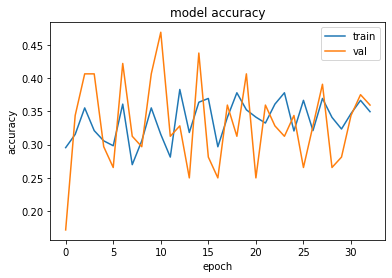

In [ ]:
# Show history of model's accuracy on train and test dataset over epoch values
model_history_1 = history_1.history

plt.figure()
plt.plot(model_history_1['accuracy'])
plt.plot(model_history_1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.savefig('accuracy')
plt.show()

**Nhận xét:**

Có thể thấy accuracy trên cả tập Train và Validation đều rất hỗn loạn và rất thấp, chủ yếu ở mức 0.3 – 0.35. Và theo kết quả chạy được thì val_loss tốt nhất nhận được là 1.14739.

### EfficientNetB7

In [ ]:
eff = efn.EfficientNetB7(include_top=False, weights='noisy-student', pooling='avg', input_shape=(124, 124, 3))

model = Sequential()
model.add(eff)
model.add(L.Dense(4, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

258072576/258068648 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________
None


In [ ]:
## Fit the Model with training dataset
history_3 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=40,
                      steps_per_epoch=train_ds.samples//128,
                      validation_steps=val_ds.samples//128,
                      callbacks=[checkpoint_3,earlystop])

Epoch 1/40
11/11 [==============================] - 67s 3s/step - loss: 1.5845 - accuracy: 0.2898 - val_loss: 2.4020 - val_accuracy: 0.3125

Epoch 00001: val_loss improved from inf to 2.40199, saving model to efficientnet.h5
Epoch 2/40
11/11 [==============================] - 22s 2s/step - loss: 1.4587 - accuracy: 0.3665 - val_loss: 3.6887 - val_accuracy: 0.3125

Epoch 00002: val_loss did not improve from 2.40199
Epoch 3/40
11/11 [==============================] - 22s 2s/step - loss: 1.3538 - accuracy: 0.4184 - val_loss: 1.5215 - val_accuracy: 0.3125

Epoch 00003: val_loss improved from 2.40199 to 1.52151, saving model to efficientnet.h5
Epoch 4/40
11/11 [==============================] - 22s 2s/step - loss: 1.2801 - accuracy: 0.4148 - val_loss: 1.2614 - val_accuracy: 0.4375

Epoch 00004: val_loss improved from 1.52151 to 1.26143, saving model to efficientnet.h5
Epoch 5/40
11/11 [==============================] - 22s 2s/step - loss: 1.2305 - accuracy: 0.4403 - val_loss: 1.3560 - val_ac

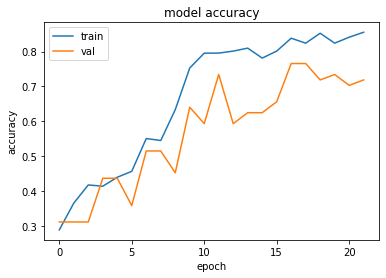

In [ ]:
# Show history of model's accuracy on train and test dataset over epoch values
model_history_3 = history_3.history

plt.figure()
plt.plot(model_history_3['accuracy'])
plt.plot(model_history_3['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.savefig('accuracy')
plt.show()

**Nhận xét:**

Có thể thấy accuracy ở cả tập Train và Validation đều được cải thiện so với mô hình ResNet. Và có vẻ ổn định trong khoảng epoch từ 10 đến 15 với accuracy trên cả 2 tập ở mức  0.7 – 0.8. Theo kết quả chạy được thì val_loss tốt nhất nhận được là 0.76227.

### DenseNet




In [ ]:
densenet = tf.keras.Sequential([DenseNet121(input_shape=(124, 124, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(4, activation='softmax')])
densenet.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
densenet.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
## Fit the Model with training dataset
history_2 = densenet.fit(train_ds,
                      validation_data=val_ds,
                      epochs=40,
                      steps_per_epoch=train_ds.samples//128,
                      validation_steps=val_ds.samples//128,
                      callbacks=[checkpoint_2,earlystop])

Epoch 1/40
11/11 [==============================] - 38s 2s/step - loss: 1.2465 - accuracy: 0.5795 - val_loss: 6.0381 - val_accuracy: 0.3438

Epoch 00001: val_loss improved from inf to 6.03813, saving model to densenet.h5
Epoch 2/40
11/11 [==============================] - 21s 2s/step - loss: 1.0558 - accuracy: 0.7102 - val_loss: 12.1031 - val_accuracy: 0.2344

Epoch 00002: val_loss did not improve from 6.03813
Epoch 3/40
11/11 [==============================] - 21s 2s/step - loss: 0.9290 - accuracy: 0.6818 - val_loss: 61.0932 - val_accuracy: 0.3281

Epoch 00003: val_loss did not improve from 6.03813
Epoch 4/40
11/11 [==============================] - 21s 2s/step - loss: 0.7956 - accuracy: 0.7500 - val_loss: 28.2684 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 6.03813
Epoch 5/40
11/11 [==============================] - 21s 2s/step - loss: 0.7010 - accuracy: 0.7699 - val_loss: 86.0054 - val_accuracy: 0.4062

Epoch 00005: val_loss did not improve from 6.03813
Epoch 6

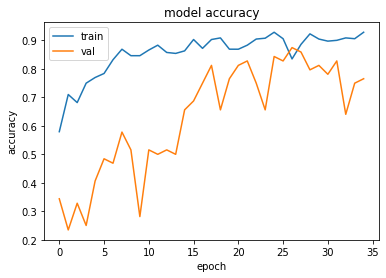

In [ ]:
# Show history of model's accuracy on train and test dataset over epoch values
model_history_2 = history_2.history

plt.figure()
plt.plot(model_history_2['accuracy'])
plt.plot(model_history_2['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.savefig('accuracy')
plt.show()

**Nhận xét:**

Có thể thấy accuracy ở cả tập Train và Validation đều được cải thiện so với mô hình ResNet và EfficientNet. Và có vẻ ổn định trong khoảng epoch từ 25 đến 30 với accuracy trên cả 2 tập ở mức 0.8 – 0.9. Theo kết quả chạy được thì val_loss tốt nhất nhận được là 0.35555.

## Testing

**Nhận xét:**

Từ kết quả trên tập Train và Validation thì có thể thấy DenseNet cho kết quả tốt nhất vì vậy sử dụng mô hình này để dự đoán tập Test.

In [ ]:
 densenet.load_weights('densenet.h5')

In [ ]:
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [ ]:
test_df.image_id = test_df.image_id.apply(lambda x: x+'.jpg')
test_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0.jpg,0.25,0.25,0.25,0.25
1,Test_1.jpg,0.25,0.25,0.25,0.25
2,Test_2.jpg,0.25,0.25,0.25,0.25
3,Test_3.jpg,0.25,0.25,0.25,0.25
4,Test_4.jpg,0.25,0.25,0.25,0.25


In [ ]:
## import test image dataset
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

INPUT_SIZE = (HEIGHT,WIDTH,3)

test_generator =  test_datagen.flow_from_dataframe(
    test_df,
    directory=IMAGES_PATH,
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)


Found 1821 validated image filenames.


In [ ]:
## predict test images
preds = densenet.predict(test_generator)
print(preds)

[[2.7274720e-03 7.6606089e-01 5.8882028e-02 1.7232957e-01]
 [8.7929780e-10 1.6078264e-03 9.9839216e-01 1.0454994e-09]
 [5.2385189e-05 3.0521646e-01 6.9092560e-01 3.8056071e-03]
 ...
 [3.3129149e-04 2.2659139e-01 7.7000523e-01 3.0721044e-03]
 [1.2638531e-06 2.2883661e-01 1.0775386e-04 7.7105445e-01]
 [5.3618571e-10 5.4349191e-04 9.9945647e-01 2.7863638e-09]]


In [ ]:
test_df[cols] = preds

In [ ]:
test_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0.jpg,2.727472e-03,0.766061,0.058882,1.723296e-01
1,Test_1.jpg,8.792978e-10,0.001608,0.998392,1.045499e-09
2,Test_2.jpg,5.238519e-05,0.305216,0.690926,3.805607e-03
3,Test_3.jpg,1.018201e-03,0.063575,0.000527,9.348801e-01
4,Test_4.jpg,5.942808e-02,0.009689,0.930551,3.319252e-04
...,...,...,...,...,...
1816,Test_1816.jpg,6.876115e-01,0.134234,0.027363,1.507924e-01
1817,Test_1817.jpg,3.336060e-03,0.074003,0.001342,9.213194e-01
1818,Test_1818.jpg,3.312915e-04,0.226591,0.770005,3.072104e-03
1819,Test_1819.jpg,1.263853e-06,0.228837,0.000108,7.710544e-01
